In [1]:
#run only for the collab not in local
from google.colab import files
files.upload()  # Upload your kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"whitewolf18","key":"5791652d7a3c416e1d99a4ebba0fe6f4"}'}

In [2]:
#run only for the collab not in local
import os
import zipfile

os.makedirs('/root/.kaggle', exist_ok=True)

!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [3]:
!kaggle datasets download iamsouravbanerjee/indian-food-images-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/iamsouravbanerjee/indian-food-images-dataset
License(s): other
 91% 324M/355M [00:00<00:00, 705MB/s]
100% 355M/355M [00:00<00:00, 671MB/s]


In [4]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [5]:
os.remove("List of Indian Foods.txt")

In [6]:
os.rename("Indian Food Images", "dataset")

In [7]:
DATA_DIR = "dataset/Indian Food Images"

In [8]:
food_list = os.listdir(DATA_DIR)

In [9]:
food_list

['ariselu',
 'aloo_gobi',
 'sohan_papdi',
 'rabri',
 'kofta',
 'modak',
 'kachori',
 'chapati',
 'adhirasam',
 'paneer_butter_masala',
 'chikki',
 'unni_appam',
 'jalebi',
 'chana_masala',
 'aloo_tikki',
 'ledikeni',
 'sohan_halwa',
 'sheer_korma',
 'kuzhi_paniyaram',
 'pithe',
 'lassi',
 'lyangcha',
 'imarti',
 'navrattan_korma',
 'litti_chokha',
 'daal_puri',
 'chicken_tikka',
 'qubani_ka_meetha',
 'gavvalu',
 'bhindi_masala',
 'chhena_kheeri',
 'dum_aloo',
 'palak_paneer',
 'malapua',
 'chicken_tikka_masala',
 'ghevar',
 'basundi',
 'bhatura',
 'doodhpak',
 'maach_jhol',
 'mysore_pak',
 'poha',
 'misi_roti',
 'double_ka_meetha',
 'kalakand',
 'dal_makhani',
 'aloo_matar',
 'shankarpali',
 'boondi',
 'anarsa',
 'gajar_ka_halwa',
 'daal_baati_churma',
 'aloo_methi',
 'butter_chicken',
 'shrikhand',
 'misti_doi',
 'makki_di_roti_sarson_da_saag',
 'kadhi_pakoda',
 'aloo_shimla_mirch',
 'sheera',
 'biryani',
 'ras_malai',
 'dal_tadka',
 'rasgulla',
 'chicken_razala',
 'naan',
 'phirni',


In [10]:
len(food_list)

80

In [11]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [12]:
def create_file_list():
    """Create a list of (file_path, label) tuples instead of loading all images"""
    file_list = []
    for food in food_list:
        food_dir = os.path.join(DATA_DIR, food)
        if os.path.isdir(food_dir):
            for img_file in os.listdir(food_dir):
                img_path = os.path.join(food_dir, img_file)
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_list.append((img_path, food))
    return file_list

In [13]:
file_list = create_file_list()
print(f"Total files found: {len(file_list)}")

Total files found: 4000


In [14]:
def get_train_test_split(file_list, test_size=0.2):
    """Split file paths into train and test sets"""
    np.random.shuffle(file_list)
    split_index = int(len(file_list) * (1 - test_size))
    train_files = file_list[:split_index]
    test_files = file_list[split_index:]
    return train_files, test_files

In [15]:
train_files, test_files = get_train_test_split(file_list)
print(f"Training files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

Training files: 3200
Test files: 800


In [16]:
class ImageDataGenerator(Sequence):
    def __init__(self, file_list, label_encoder, num_classes, batch_size=32, shuffle=True):
        self.file_list = file_list
        self.label_encoder = label_encoder
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        # Get batch indexes
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.file_list))
        batch_indexes = self.indexes[start_idx:end_idx]

        # Generate batch data
        batch_x = []
        batch_y = []

        for idx in batch_indexes:
            img_path, label = self.file_list[idx]
            try:
                img_array = load_and_preprocess_image(img_path)
                batch_x.append(img_array[0])  # Remove the extra dimension
                batch_y.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue

        if len(batch_x) == 0:
            return np.array([]), np.array([])

        # Encode labels and convert to one-hot
        batch_y_encoded = self.label_encoder.transform(batch_y)
        batch_y_one_hot = to_categorical(batch_y_encoded, num_classes=self.num_classes)

        return np.array(batch_x), batch_y_one_hot

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [17]:

batch_size = 16


all_labels = [label for _, label in file_list]
unique_labels = list(set(all_labels))
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)
num_classes = len(unique_labels)

train_generator = ImageDataGenerator(train_files, label_encoder, num_classes, batch_size=batch_size, shuffle=True)
test_generator = ImageDataGenerator(test_files, label_encoder, num_classes, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_generator)}")
print(f"Test batches: {len(test_generator)}")
print(f"Batch size: {batch_size}")
print(f"Number of classes: {num_classes}")


Training batches: 200
Test batches: 50
Batch size: 16
Number of classes: 80


In [18]:

sample_batch_x, sample_batch_y = train_generator[0]
print(f"Sample batch shape: {sample_batch_x.shape}")
print(f"Sample labels: {sample_batch_y[:5]}")

Sample batch shape: (16, 300, 300, 3)
Sample labels: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [19]:
# Check generator information
print(f"Total training files: {len(train_files)}")
print(f"Total test files: {len(test_files)}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Test batches: {len(test_generator)}")

# Test loading one batch to verify everything works
sample_x, sample_y = train_generator[0]
print(f"Sample batch X shape: {sample_x.shape}")
print(f"Sample batch Y shape: {sample_y.shape}")

Total training files: 3200
Total test files: 800
Training batches per epoch: 200
Test batches: 50
Sample batch X shape: (16, 300, 300, 3)
Sample batch Y shape: (16, 80)


In [20]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print(f"Model created with {num_classes} output classes")

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Model created with 80 output classes


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,906,495 (41.60 MB)

 Trainable params: 122,960 (480.31 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    verbose=1
)

print("Training completed successfully!")

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1520 - loss: 3.8161

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 156ms/step - accuracy: 0.1526 - loss: 3.8131 - val_accuracy: 0.4913 - val_loss: 2.2615
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.6050 - loss: 1.8484 - val_accuracy: 0.5587 - val_loss: 1.7721
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.7136 - loss: 1.2881 - val_accuracy: 0.5875 - val_loss: 1.5759
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.7919 - loss: 0.9757 - val_accuracy: 0.5863 - val_loss: 1.5036
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.8219 - loss: 0.8339 - val_accuracy: 0.6175 - val_loss: 1.4198
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.8556 - loss: 0.7044 - val_accuracy: 0.6175 - val_loss: 1.3861
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.8953 - loss: 0.5680 - val_accuracy: 0.6237 - val_loss: 1.3522
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.9189 - loss: 0.4704 - val

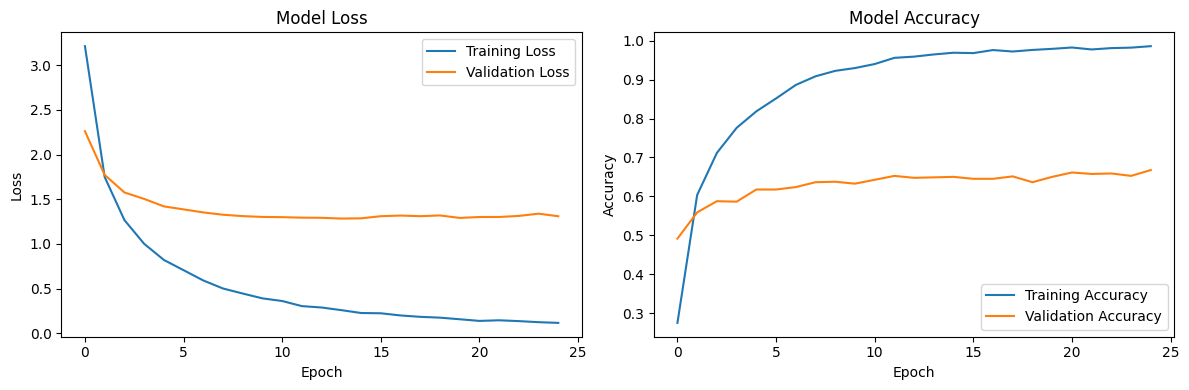

In [24]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6546 - loss: 1.3093
Test Loss: 1.3093
Test Accuracy: 0.6675


In [26]:
model.save('model.h5')
model.save('model.keras')